In [1]:
import pandas as pd
df = pd.read_csv(r"D:\graduation_project\grad_Tasks\forcasting\gold_price_data.csv")
df['Date'] = pd.to_datetime(df['Date']) 
df = df.set_index('Date')
df = df['2017-01-02':'2019-12-29'].resample('W').sum()
df.head()

,Value
Date,
2017-01-08,5813.70
2017-01-15,5941.95
2017-01-22,6030.40
2017-01-29,5999.20
2017-02-05,6046.40


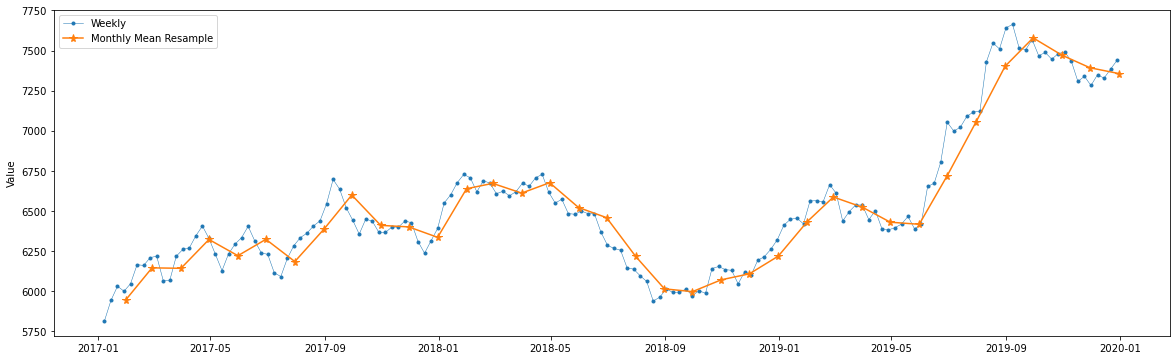

In [7]:
import warnings
import matplotlib.pyplot as plt
y = df['Value']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='*', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Value')
ax.legend();

In [8]:
import statsmodels.api as sm
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

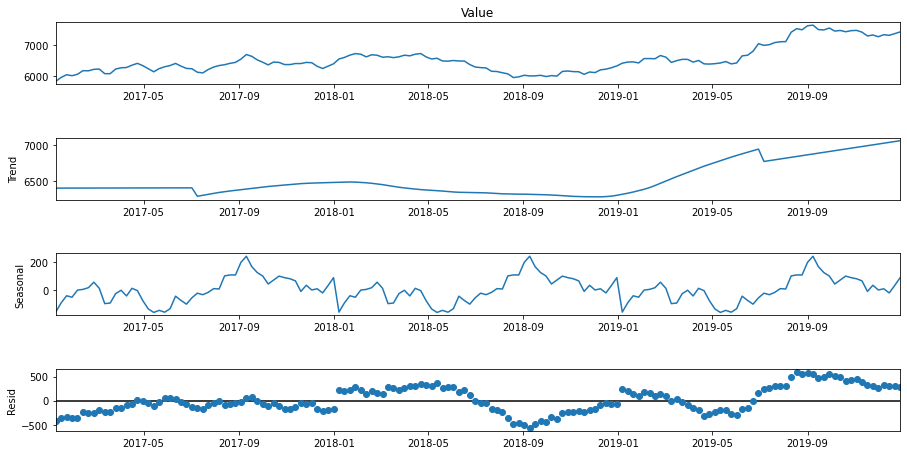

In [9]:
seasonal_decompose(y)

In [10]:
def test_stationarity(timeseries, title):
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

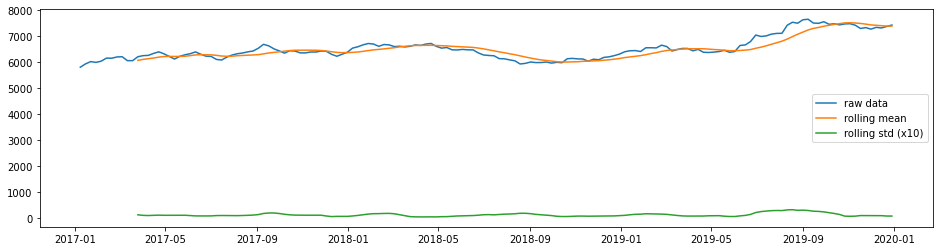

In [11]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'raw data')

In [12]:
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [13]:
ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = -0.769
P-value = 0.828
Critical values :
	1%: -3.4750180242954167 - The data is not stationary with 99% confidence
	5%: -2.8811408028842043 - The data is not stationary with 95% confidence
	10%: -2.577221358046935 - The data is not stationary with 90% confidence


 > Is the de-trended data stationary ?
Test statistic = -3.515
P-value = 0.008
Critical values :
	1%: -3.476597917537401 - The data is  stationary with 99% confidence
	5%: -2.8818291230495543 - The data is  stationary with 95% confidence
	10%: -2.5775887982253085 - The data is  stationary with 90% confidence


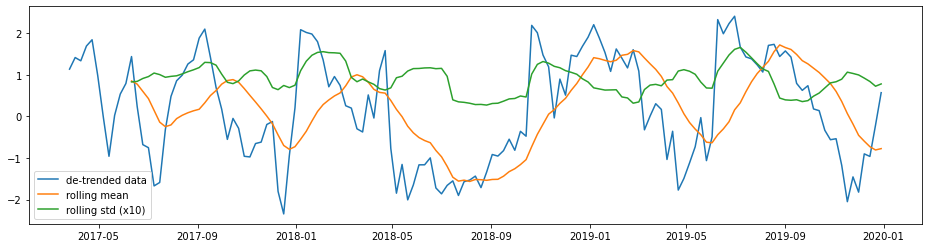

In [14]:
y_detrend = (y - y.rolling(window=12).mean())/y.rolling(window=12).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

 > Is the 12 lag differenced data stationary ?
Test statistic = -1.988
P-value = 0.292
Critical values :
	1%: -3.481281802271349 - The data is not stationary with 99% confidence
	5%: -2.883867891664528 - The data is not stationary with 95% confidence
	10%: -2.5786771965503177 - The data is not stationary with 90% confidence


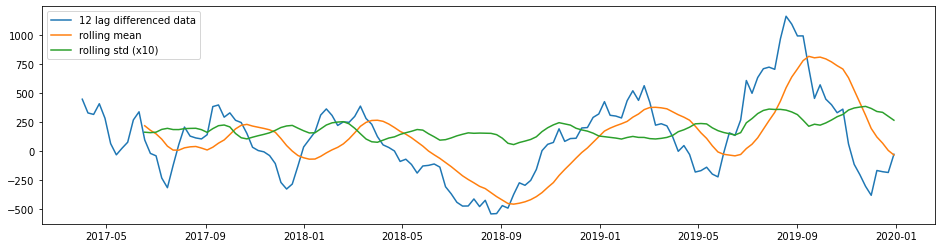

In [15]:
y_12lag =  y - y.shift(12)

test_stationarity(y_12lag,'12 lag differenced data')
ADF_test(y_12lag,'12 lag differenced data')

 > Is the 12 lag differenced de-trended data stationary ?
Test statistic = -3.361
P-value = 0.012
Critical values :
	1%: -3.486055829282407 - The data is not stationary with 99% confidence
	5%: -2.8859430324074076 - The data is  stationary with 95% confidence
	10%: -2.5797850694444446 - The data is  stationary with 90% confidence


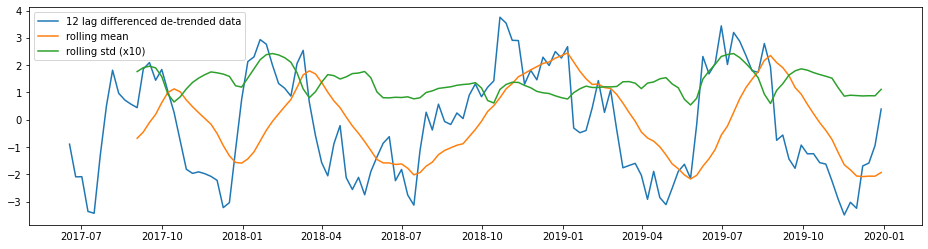

In [16]:
y_12lag_detrend =  y_detrend - y_detrend.shift(12)

test_stationarity(y_12lag_detrend,'12 lag differenced de-trended data')
ADF_test(y_12lag_detrend,'12 lag differenced de-trended data')

In [17]:
y_to_train = y[:'2017-04-10'] 
y_to_val = y['2019-09-02':]   
predict_date = len(y) - len(y[:'2019-06-02']) 

In [18]:
import numpy as np
from statsmodels.tsa.api import SimpleExpSmoothing 

def ses(y, y_to_train,y_to_test,smoothing_level,predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    fit1 = SimpleExpSmoothing(y_to_train).fit(smoothing_level=smoothing_level,optimized=False)
    fcast1 = fit1.forecast(predict_date).rename(r'$\alpha={}$'.format(smoothing_level))
    # specific smoothing level
    fcast1.plot(marker='o', color='blue', legend=True)
    fit1.fittedvalues.plot(marker='o',  color='blue')
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with smoothing level of {} is {}'.format(smoothing_level,round(np.sqrt(mse1), 2)))
    
    ## auto optimization
    fit2 = SimpleExpSmoothing(y_to_train).fit()
    fcast2 = fit2.forecast(predict_date).rename(r'$\alpha=%s$'%fit2.model.params['smoothing_level'])
    # plot
    fcast2.plot(marker='o', color='green', legend=True)
    fit2.fittedvalues.plot(marker='o', color='green')
    
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with auto optimization is {}'.format(round(np.sqrt(mse2), 2)))
    
    plt.show()

The Root Mean Squared Error of our forecasts with smoothing level of 0.8 is nan
The Root Mean Squared Error of our forecasts with auto optimization is nan


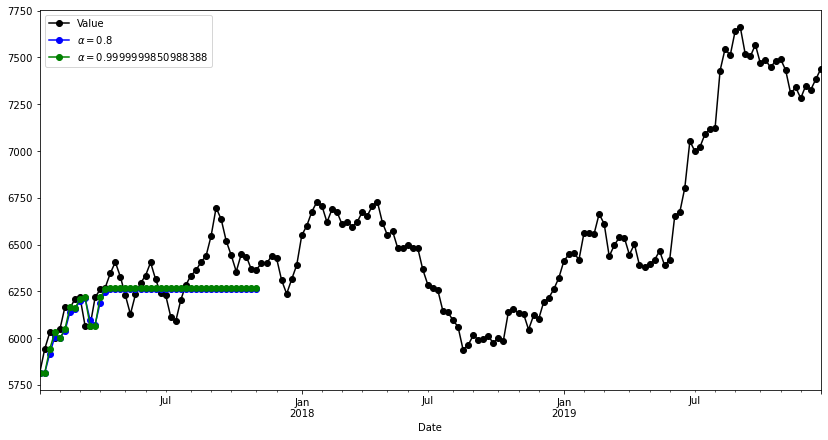

In [19]:
ses(y, y_to_train,y_to_val,0.8,predict_date)

In [20]:
from statsmodels.tsa.api import Holt

def holt(y,y_to_train,y_to_test,smoothing_level,smoothing_slope, predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    fit1 = Holt(y_to_train).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast1 = fit1.forecast(predict_date).rename("Holt's linear trend")
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of Holt''s Linear trend {}'.format(round(np.sqrt(mse1), 2)))

    fit2 = Holt(y_to_train, exponential=True).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast2 = fit2.forecast(predict_date).rename("Exponential trend")
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of Holt''s Exponential trend {}'.format(round(np.sqrt(mse2), 2)))
    
    fit1.fittedvalues.plot(marker="o", color='blue')
    fcast1.plot(color='blue', marker="o", legend=True)
    fit2.fittedvalues.plot(marker="o", color='red')
    fcast2.plot(color='red', marker="o", legend=True)

    plt.show()

The Root Mean Squared Error of Holts Linear trend nan
The Root Mean Squared Error of Holts Exponential trend nan


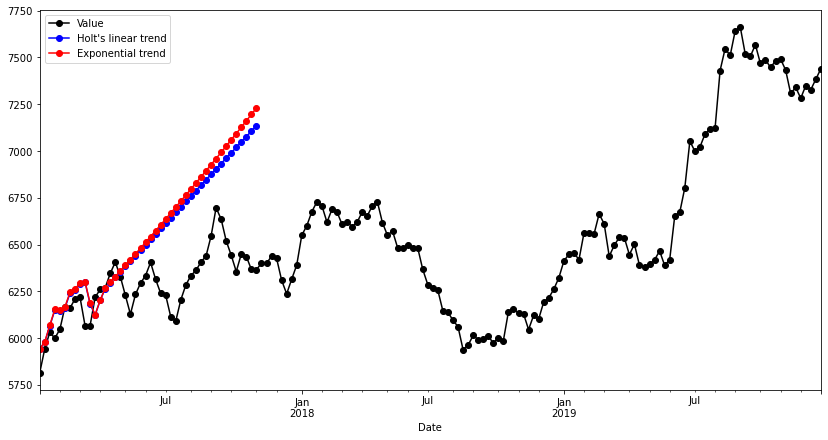

In [21]:
holt(y, y_to_train,y_to_val,0.6,0.2,predict_date)

In [22]:
import itertools

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#              
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))
    


In [23]:
sarima_grid_search(y,52)

D:\graduation_project\IEEE_ML_traninig\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
D:\graduation_project\IEEE_ML_traninig\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
D:\graduation_project\IEEE_ML_traninig\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
D:\graduation_project\IEEE_ML_traninig\anaconda\l

The set of parameters with the minimum AIC is: SARIMA(0, 1, 1)x(1, 1, 1, 52) - AIC:593.71600817841
